<h1><center>Applying Data Science on eSports - A Dota2 Case</center></h1>
<h2><center>Predict the Results of an Upcoming Event</center></h2>

### Introduction
In recent years, as several multiplayer competition games became popular all over the world with loyal player groups of 10-100 million scale, the professional gaming (eSports) developed rapidly.  Supported by the expansion of the eSports, despite of the fundamental roles like players and coaches, some new roles like “Data/Stats Analyst” are introduced into eSports industry just like the other highly developed “traditional sports” (NBA, FIFA, etc.).  From the experiences of the traditional sports, the comprehensive scientific analysis of the data could help the professionals identify the potential problems and find better plans to improve the performance, from individual training to organization management.  However, the data analysis in eSports is at a lower level than in traditional sports.  Most analyses focus only on statistical data collection and visualization ([Dotabuff](https://www.dotabuff.com/),[Dotamax](http://dotamax.com/home/),[Nahaz](https://www.youtube.com/channel/UCHgkSS3Vc-TIH1Wd64Hq_dQ)(famous individual analyst),etc.) and the deeper analysis techniques in data science are rarely applied.

In this tutorial, we will go through a basic (but complete) data lifecycle to perform analysis on 8 teams in an upcoming Dota2 tournament ([SL i-League Dota 2 Invitational S2](https://starladder.com/en/dota-2-invitational-s2)).  
<img src="files/A.png" alt="Drawing" style="width: 600px;"/>
<h3><center>John P Dickerson, Data Science Prof.  UMD</center></h3>
We will be able to get various results/hypotheses from this process but to make the tutorial more concentrated and build a clear workflow, we set the primary goal of this tutorial as to predict the results of the game matches in the entire event based on machine learning.

Please read [Dota Wiki](http://dota2.gamepedia.com/Dota_2_Wiki) for detailed introduction of the Dota2 gameplay.

### Contents of the Tutorial
[Environment](#Envrioment ) <br/>
[Data Collection](#Data-Collection)<br/>
[Data Process](#Data-Process )<br/>
[Exploratory Analysis](#Exploratory-Analysis )<br/>
[Machine Learning](#Machine-Learning )<br/>
[Summary and Insights](#Summary-and-Insight )<br/>
[Documentations](#Documentations )<br/>
[References](#References)

### Envrioment 
This tutorial is based on Python 3.6.0 and requires following libraries.
There is one .py file named util17py which contains custom functions to support this project.
Datasets and util17py could be found in the project repo:https://github.com/zhouy1017/Project-DotDota.

In [321]:
import dota2api
import numpy as np
import pandas as pd
import requests
import time 
import util17py
import matplotlib
import matplotlib.pyplot as plt
from datetime import datetime
from matplotlib.dates import date2num
from sklearn.linear_model import LogisticRegressionCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier
import warnings
warnings.filterwarnings('ignore')

### Data Collection
Unlike other activities in real world, eSports are based on computer programs which means all gaming match data are generated, collected and stored electronically.  Technically we should be able to collect the data from the data server without extra physical devices (like GPS in football) or manual input.  However, not all game operators are willing to provide match data to public or provide all details of the raw data.  For Dota 2, we have following options:
    1.	The official API provided by Valve Software. 
    (Including Third party database like [Dotabuff](https://www.dotabuff.com/) that based on this API.)
    2.	Replay parsing based database.
    3.	Manual collection.
Option 2 could provide more details than Option 1 because the replay of a match will cover all information while the API does not.  And due to some wrong logged changes (roster registration,etc),the information in the game server might be incorrect.  After consideration, to collect necessary data for our tutorial, we will combine all the options.  We will use [Datdota](http://datdota.com/) in Option2 to download the lists of matches of all 8 teams in our event and merge them as our main dataset.  And then use official API to get details of matches in the dataset.  Some trivial information that could not be accessed programmatically such as “which 8 teams are in the event” will be collected manually.


We firstly get to know the 8 teams in the event from [liquidpedia](http://wiki.teamliquid.net/dota2/StarLadder/i-League_Invitational/2) and record them in a list.
<img src="files/B.png" alt="Drawing" style="width: 600px;"/>
<h3><center>Participants from Liquidpedia</center></h3>

In [2]:
team_lst = ['Alliance','Newbee','Team Faceless','Team Liquid','TNC Pro Team','Vega Squadron','Invictus Gaming','Team VGJ']


And then we could download the 8 csv files from [Datdota](http://datdota.com/) for each team. (The GitHub repo contains the files I downloaded in /dataset, since there are ongoing events, records might change anytime.)  Those files will contain all professional matches those 8 teams played with records on Dota2 game server.
Load those files as dataframe and then merge them.


In [3]:
# load the csv files
ig = pd.read_csv("dataset/ig.csv")
nb = pd.read_csv("dataset/nb.csv")
alli = pd.read_csv("dataset/Alliance.csv")
fl = pd.read_csv("dataset/fl.csv")
tl = pd.read_csv("dataset/Team Liquid.csv")
vs = pd.read_csv("dataset/Vega Squadron.csv")
vgj = pd.read_csv("dataset/VGJ.csv")
tnc = pd.read_csv("dataset/TNC Pro Team.csv")
# merge as one called dataset
frames = [alli,nb,fl,tl,tnc,vs,ig,vgj]
dataset = pd.concat(frames, keys=team_lst)
dataset.head()

Match         Date  League       Opponent Result
Alliance 0  3178869138  14 May 2017    4442    Team Empire   Loss
         1  3178589992  14 May 2017    4442    Team Empire    Win
         2  3178374532  14 May 2017    4442    Team Empire   Loss
         3  3176125586  13 May 2017    4442  Natus Vincere   Loss
         4  3175916756  13 May 2017    4442  Natus Vincere   Loss

Now we have a list of all matches those 8 teams played.  For the goal to perform machine learning on the match data, we need to have more details for each match by get match details through dota2api.

Note: dota2api requires a special key from Steam.  Follow the tutorial here before the next step: https://dota2api.readthedocs.io/en/latest/tutorial.html


In [9]:
# initialize the dota2api
api = dota2api.Initialise()
# get the match details by dota2api and append the raw details as a new column
lst = [] # empty list to store the results
for matchid in dataset['Match'].tolist():
    # get the detail
    detail = api.get_match_details(match_id=matchid)
    # add to the result list
    lst.append(detail)
    # the dota2api requires to send no more than 1 request per second.
    # please read the docs of dota2api and steam web api for more details.
    # due to the request limitation, the code will take a long time.  So save time, you could use
    # my dataset 'dataset.csv' dumped in my repo or other dumped source.
    time.sleep(1)
    #print (len(lst)) # debug code
    
    # this code could be revised to retry the current match while get exception from api server.
    # please read http://stackoverflow.com/questions/2083987/how-to-retry-after-exception-in-python for more.

In [10]:
# add the details to the dataset as a new column
dataset['Detail'] = lst
# dump the dataset as pkl to file
# due to the limitation of the size, the file in repo is compressed as .7z
dataset.to_pickle('dataset.pkl')
dataset.head()

Match         Date  League       Opponent Result  \
Alliance 0  3178869138  14 May 2017    4442    Team Empire   Loss   
         1  3178589992  14 May 2017    4442    Team Empire    Win   
         2  3178374532  14 May 2017    4442    Team Empire   Loss   
         3  3176125586  13 May 2017    4442  Natus Vincere   Loss   
         4  3175916756  13 May 2017    4442  Natus Vincere   Loss   

                                                       Detail  
Alliance 0  {'players': [{'account_id': 12231202, 'player_...  
         1  {'players': [{'account_id': 12231202, 'player_...  
         2  {'players': [{'account_id': 12231202, 'player_...  
         3  {'players': [{'account_id': 87285329, 'player_...  
         4  {'players': [{'account_id': 87285329, 'player_...

Now we have all raw data of the match history.  However, before we can do actual analysis on the data, we need to process the data into more readable forms, especially for especially for ‘Detail’ column.


### Data Process
We will get features like ‘first blood time’, ‘radiant or dire’ (the position of team in game), etc. And add the patch versions depending on the date of the match.

In [12]:
# change the index of the team into a column
dataset['Team'] = dataset.index
dataset['Team'] = dataset['Team'].map(lambda x:str(x).split(',')[0].split('(')[1])
# drop the duplicate matches (since a match between 8 teams will be recorded twice in each team's section).
# dataset = dataset.drop_duplicates(col = ['Match'])
dataset.head()

Match         Date  League       Opponent Result  \
Alliance 0  3178869138  14 May 2017    4442    Team Empire   Loss   
         1  3178589992  14 May 2017    4442    Team Empire    Win   
         2  3178374532  14 May 2017    4442    Team Empire   Loss   
         3  3176125586  13 May 2017    4442  Natus Vincere   Loss   
         4  3175916756  13 May 2017    4442  Natus Vincere   Loss   

                                                       Detail        Team  
Alliance 0  {'players': [{'account_id': 12231202, 'player_...  'Alliance'  
         1  {'players': [{'account_id': 12231202, 'player_...  'Alliance'  
         2  {'players': [{'account_id': 12231202, 'player_...  'Alliance'  
         3  {'players': [{'account_id': 87285329, 'player_...  'Alliance'  
         4  {'players': [{'account_id': 87285329, 'player_...  'Alliance'

In [13]:
# add versions
lst = []
for date in dataset['Date']:
    ver = util22.version(str(date)) # use the function in util.py
    lst.append(ver)
dataset['Version'] = lst

In [14]:
# parse other features
if True:
    fb = []
    dua = []
    dire = []
    radiant = []
    ra_GPM = []
    di_GPM = []
    ra_XPM = []
    di_XPM = []
    ra_kill = []
    di_kill = []
    ra_death = []
    di_death = []
    ra_assi = []
    ra_herodmg = []
    ra_towerdmg = []
    ra_lh = []
    ra_denies = []
    di_herodmg = []
    di_towerdmg = []
    di_lh = []
    di_denies = []
    di_assi = []
    i = 0
    dlst = dataset['Detail'].tolist()
    teamlst = dataset['Team'].tolist()
    oppolst = dataset['Opponent'].tolist()
    while i < len(dlst):    
        fb.append(dlst[i]['first_blood_time'])
        dua.append(dlst[i]['duration'])
        
        # differ the sides by win/loss 
        try:
            
            if dataset['Result'].tolist()[i] == 'Win':
                if dlst[i]['radiant_win']:
                    radiant.append(teamlst[i])
                    dire.append(oppolst[i])
                else:
                    dire.append(teamlst[i])
                    radiant.append(oppolst[i])   
            else:
                if dlst[i]['radiant_win']:
                    dire.append(teamlst[i])
                    radiant.append(oppolst[i])
                else:
                    radiant.append(teamlst[i])
                    dire.append(oppolst[i]) 
        except KeyError:# the api has issues for missing data of the old game records, we will handle it here.
            radiant.append(np.nan)
            dire.append(np.nan)
        # add the features of 5 players up to the team's features
        j = 0
        rgpm, rxpm,rkill,rdeath,rlh,rdines,rhd,rtd,rass = 0,0,0,0,0,0,0,0,0
        dgpm, dxpm,dkill,ddeath,dlh,ddines,dhd,dtd,dass = 0,0,0,0,0,0,0,0,0
        while j < 5:
            
            rgpm += dlst[i]['players'][j]['gold_per_min']
            rxpm += dlst[i]['players'][j]['xp_per_min']
            rkill += dlst[i]['players'][j]['kills']
            rass += dlst[i]['players'][j]['assists']
            rlh += dlst[i]['players'][j]['last_hits']
            rdines += dlst[i]['players'][j]['denies']
            rdeath += dlst[i]['players'][j]['deaths']
            j += 1
           
        while j < 10:
            dgpm += dlst[i]['players'][j]['gold_per_min']
            dxpm += dlst[i]['players'][j]['xp_per_min']
            dkill += dlst[i]['players'][j]['kills']
            dass += dlst[i]['players'][j]['assists']
            dlh += dlst[i]['players'][j]['last_hits']
            ddines += dlst[i]['players'][j]['denies']
            ddeath += dlst[i]['players'][j]['deaths']
            j += 1
        # add to the lists
        ra_GPM.append(rgpm)
        ra_XPM.append(rxpm)
        ra_kill.append(rkill)
        ra_death.append(rdeath)
        ra_assi.append(rass)
        ra_herodmg.append(rhd)
        ra_towerdmg.append(rtd)
        ra_lh.append(rlh)
        ra_denies.append(rdines)
        di_GPM.append(dgpm)
        di_XPM.append(dxpm)
        di_kill.append(dkill)
        di_death.append(ddeath)
        di_assi.append(dass)
        di_herodmg.append(dhd)
        di_towerdmg.append(dtd)
        di_lh.append(dlh)
        di_denies.append(ddines)
        i += 1

    # add to dataframe
dataset['Ra_GPM'] = ra_GPM
dataset['Ra_XPM'] = ra_XPM
dataset['Ra_kill'] = ra_kill
dataset['Ra_death'] = ra_death
dataset['Ra_assistant'] = ra_assi
dataset['Ra_last hit'] = ra_lh
dataset['Ra_denies'] = ra_denies
dataset['Di_GPM'] = di_GPM
dataset['Di_XPM'] = di_XPM
dataset['Di_kill'] = di_kill
dataset['Di_death'] = di_death
dataset['Di_assistant'] = di_assi
dataset['Di_last hit'] = di_lh
dataset['Di_denies'] = di_denies
dataset['Duration'] = dua
dataset['First_blood'] = fb
dataset['Radiant'] = radiant

# def a function to transfer win/loss to 1/0
def winrate(s):
    if s == 'Win':
        return 1
    else:
        return 0
dataset['Result'] = dataset['Result'].map(winrate)
dataset.head()

Match         Date  League       Opponent  Result  \
Alliance 0  3178869138  14 May 2017    4442    Team Empire       0   
         1  3178589992  14 May 2017    4442    Team Empire       1   
         2  3178374532  14 May 2017    4442    Team Empire       0   
         3  3176125586  13 May 2017    4442  Natus Vincere       0   
         4  3175916756  13 May 2017    4442  Natus Vincere       0   

                                                       Detail        Team  \
Alliance 0  {'players': [{'account_id': 12231202, 'player_...  'Alliance'   
         1  {'players': [{'account_id': 12231202, 'player_...  'Alliance'   
         2  {'players': [{'account_id': 12231202, 'player_...  'Alliance'   
         3  {'players': [{'account_id': 87285329, 'player_...  'Alliance'   
         4  {'players': [{'account_id': 87285329, 'player_...  'Alliance'   

           Version  Ra_GPM  Ra_XPM      ...        Di_GPM  Di_XPM  Di_kill  \
Alliance 0    7.05    2072    2124      ...          2193    2530       28   
         1    7.05    2506    2485      ...          2412    2455       44   
         2    7.05    2030    2232      ...          2469    2632       24   
         3    7.05    2408    2272      ...          2441    2543       78   
         4    7.05    2313    2481      ...          2243    2270       39   

            Di_death  Di_assistant  Di_last hit  Di_denies  Duration  \
Alliance 0        20            72          895         35      2525   
         1        45            84         1948         35      4342   
         2        20            51         1224         19      2697   
         3        49           192         3045         35      6544   
         4        29           107         1689         76      3866   

            First_blood        Radiant  
Alliance 0          253     'Alliance'  
         1          130     'Alliance'  
         2          197     'Alliance'  
         3           50  Natus Vincere  
         4          449  Natus Vincere  

[5 rows x 25 columns]

Now we have the basic performance data of each team to evalute how well they played in all pro matches.

### Exploratory Analysis
For eSports, due to the frequent roster changes and patch updates, it is hard to evaluate the performance of a pro team from a historical perspective.  Mostly, a team could only have about 100-200 matches in certain version with a certain roster.  Those changes could make the data from other versions and time periods somehow meaningless and make it difficult to identify the actual factors that influence the team.  

For example, team Alliance got 6 Premier-class champions in 2013 and only 2 in 2014 with a drop in world ranking from No.1 to 20+.  Just by looking at the GPM and XPM, we might say that the players lost their advantage in gaining gold and XP but since the patch in 2014 changed the economy system of the game, even players were doing as well as in 2013, they still could not make the same GPM and XPM.  

Furthermore, the lower winrate means Alliance lost more matches in 2014 than 2013 which would also cause the drop in GPM and XPM – the lost teams typically have deficient performance data. This is the reason why current data analysis for dota2 usually only focus on the recent data of a pro team under current versions and versions without major changes.

We could group the matches of Alliance to get their average winrate by months.


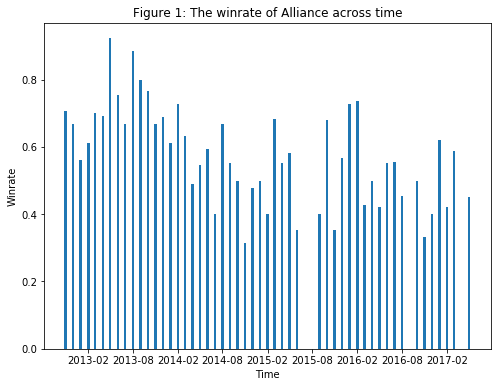

In [97]:
# copy the dataset
df = dataset.loc['Alliance']
# get the data of the Alliance (differing from its opponent)
df['GPM'] = np.nan
df['XPM'] = np.nan
GPMlst = []
XPMlst = []
for index,row in df.iterrows():
    if row['Radiant'] == 'Alliance':
        GPMlst.append(row['Ra_GPM'])
        XPMlst.append(row['Ra_XPM'])
    else:
        GPMlst.append(row['Di_GPM'])
        XPMlst.append(row['Di_XPM'])   
df['GPM'] = GPMlst
df['XPM'] = XPMlst
# change the date into month-year
df['Month'] = df['Date'].map(lambda s: s.split(" ")[1]+s.split(" ")[2]).map(lambda s: datetime.strptime(s, '%b%Y').date())
# groupby month and take the average
dfm = df.groupby(['Month'],as_index=False).mean()
# plot the winrate by time
plt.figure(11)
plt.figure(figsize=(8,6))
ax = plt.subplot(111)
ax.bar(date2num(dfm['Month']),dfm['Result'], width=10)
ax.xaxis_date()
plt.xlabel('Time')
plt.ylabel('Winrate')
plt.title('Figure 1: The winrate of Alliance across time')
plt.show()



Just like mentioned before, Alliance had a great winrate at around 2013-08 (nearly 90%) and have a noticiable drop after the 'golden time'.  And then we want to find out what factors could potentially explain this change.

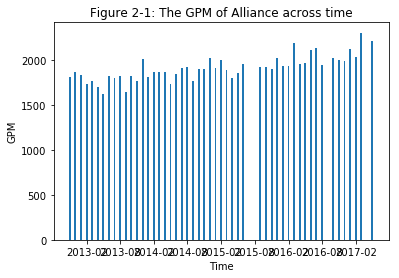

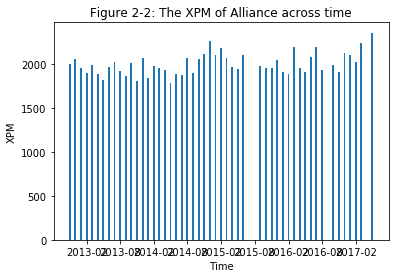

In [104]:
plt.figure(2)
ax = plt.subplot(111)
ax.bar(date2num(dfm['Month']),dfm['GPM'], width=10)
ax.xaxis_date()
plt.xlabel('Time')
plt.ylabel('GPM')
plt.title('Figure 2-1: The GPM of Alliance across time')
plt.figure(33)
ax = plt.subplot(111)
ax.bar(date2num(dfm['Month']),dfm['XPM'], width=10)
ax.xaxis_date()
plt.xlabel('Time')
plt.ylabel('XPM')
plt.title('Figure 2-2: The XPM of Alliance across time')
plt.show() 

An interesting thing in two figures is that : when the team has a higher winrate, it does not have higher GPM/XPM in historical view (instead, the team has even loer GPM/XPM during their 'happy time'), although the winner of a match would have better GPM/XPM in most cases. This reveals that there are other factors that influence the performance of the team in statistical view.  For example, the improvement of the average training level of players (in 2009, a player farmed 3800 gold in 7 minutes with a 543 GPM in a dota1 game(regarded as old patch of Dota2) and was regarded as the fastest in world, and in 2017 the average GPM of a high-level non-pro player could reach 600 GPM in very-high skills.)  and the change of versions (the gold and XP gaining speed changed) will both provide us the misleading data: it seems the performance of the team is improved although in fact it is weak when fight against other teams.  To reduce this influence of those factors, we could do a normalization/standardization on our data depending on factors chosen by us.   

We will normalize the GPM/XPM of Alliance by following formula:

\begin{equation}
X_{s} = \frac{X - \mu }{\sigma }
\end{equation}

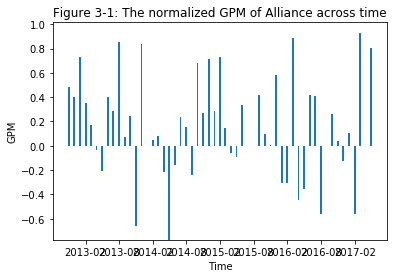

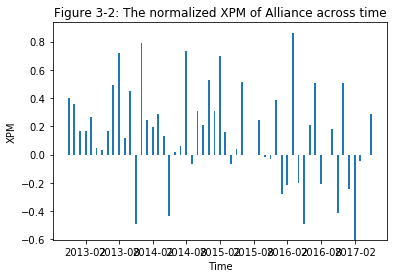

In [105]:
# calculate the average GPM/XPM by month for all teams
df2 = dataset.drop_duplicates(subset = ['Match'])
# take the average data of both sides as the data of the match
df2['GPM'] = (df2['Ra_GPM'] + df2['Di_GPM'])/2
df2['XPM'] = (df2['Ra_XPM'] + df2['Di_XPM'])/2
# add month column
df2['Month'] = df2['Date'].map(lambda s: s.split(" ")[1]+s.split(" ")[2]).map(lambda s: datetime.strptime(s, '%b%Y').date())

# compute the mean and the std of the data by months
df2m = df2.groupby(['Month']).mean()
df2s = df2.groupby(['Month']).std()
# select only needed columns
df2m['Month'] = df2m.index
df2s['Month'] = df2s.index
df2a = df2m[['Month','GPM','XPM']]
df2a.columns = ['Month','GPMm','XPMm']
df2b = df2s[['Month','GPM','XPM']]
df2b.columns = ['Month','GPMs','XPMs']
# join to Alliance
dfm = dfm.join(df2a, on = 'Month',rsuffix = 'r')
dfm = dfm.join(df2b, on = 'Month',rsuffix = 'r')

# compute new normorlized values
dfm['GPMn'] = (dfm['GPM'] - dfm['GPMm'])/dfm['GPMs']
dfm['XPMn'] = (dfm['XPM'] - dfm['XPMm'])/dfm['XPMs']

# plot 
plt.figure(3)
ax = plt.subplot(111)
ax.bar(date2num(dfm['Month']),dfm['GPMn'], width=10)
ax.xaxis_date()
plt.xlabel('Time')
plt.ylabel('GPM')
plt.title('Figure 3-1: The normalized GPM of Alliance across time')
plt.figure(33)
ax = plt.subplot(111)
ax.bar(date2num(dfm['Month']),dfm['XPMn'], width=10)
ax.xaxis_date()
plt.xlabel('Time')
plt.ylabel('XPM')
plt.title('Figure 3-2: The normalized XPM of Alliance across time')
plt.show() 

Now we can clearly see the change of the performance of the team changing by time, which could more reasonably explain the change of the winrate of the team.
Instead of the "seemed good" performance (you can even find improvement!) in raw data, we could say after the "golden time" before 2013-08, the GPM/XPM were at a lower level during 2013-08 - 2014-08 and about the year of 2016.  We have reason to concern about the stability and the overall competitivity of the team to win more matches against other teams.  And also we could find out that instead of the change of versions, other factors (roster changes, failure to adopt patches, player training badly etc.) cause the change of performance of the team since other teams (used for normalization) play under the same versions.

### Machine Learning
Now we could move to prediction by machine learning.
It is already a common idea to use the performance data (kill,death,GPM in Dota2 or score, shoot in football) as the input to represent the competitivity of a team to predict win/loss or for other analyses.  And to deal with the issue that one match will involve two different teams, Adit Deshpande has introduced a method to take the data of both teams as input at same time and then get the predictions.
The basic idea is that first make the vectors that contains all features designed for ML for both teams and then use the difference vector of the two feature-vector as the input.
We will combine the idea of Adit Desphande and the normalization in last section to make the machine learning.
We define the single vector of one team would be:
<img src="files/C.png" alt="Drawing" style="width: 600px;"/>
<h3><center>Adit Deshpande, Model Structure in Applying Machine Learning To March Madness</center></h3>

Features Set 1:<br/>
<h4><center>[first_blood_time, duration, kill, death, assistant, GPM, XPM, last_hit,denies,winrate]</center></h4><br/>
Those features would be Normalized Average of the team in the version of game that match played on.<br/>
And we also add other features to include more factors:<br/>
Features Set 2:<br/>
<h4><center>[first_blood_time, duration, kill, death, assistant, GPM, XPM, last_hit,denies,winrate]</center></h4><br/>
Those features would be Normalized Average of the team for all matches.<br/>
This will include the factor of historical performance.<br/>
Then we add a binary ‘bias’ for if the team has won the highest tournament TI (representing the most competitive team of the year).<br/>
We will have a 21 features vector for each team and use them as raw input.<br/>


In [248]:
if True:
    # get the average 10 features by version
    # add the two sides into one data
    # build the 9 feature set (except winrate)
    featurevec = ['GPM','XPM','kill','death','assi','lh','de','Dua','FB']

    # compute data for each team (not only 8 teams but all teams in dataset)
    dftv = dataset[dataset.columns[0:25]]
    dftv = dftv.reset_index()
    del dftv['level_0']
    del dftv['level_1']
    dftv = dftv.drop_duplicates(subset = ['Match'])
    radiant_lst = ['Version']
    # the df to store seperate results for each team in each match
    df_all_team = pd.DataFrame(columns = ['Team','Version','win','GPM','XPM','kill','death','assi','lh','de','Dua','FB'])
    for index,row in dftv.iterrows():

        # in each match record, we will get 2 records for each team
        lstr = []
        lstd = []
        # if team is the radiant
        if row['Radiant'] == row['Team']:
            lstr.append(str(row['Team']).split("'")[1])
            lstd.append(str(row['Opponent']))
            lstr.append(row['Version'])
            lstd.append(row['Version'])
            if int(row['Result']) == 0:
                lstr.append(0)
                lstd.append(1)
            else:
                lstd.append(0)
                lstr.append(1)  
            rdata = row[row.index[8:15]].tolist()
            ddata = row[row.index[15:22]].tolist()
            lstr.extend(rdata)
            lstd.extend(ddata)    
            lstr.append(row['Duration'])
            lstr.append(row['First_blood']) 
            lstd.append(row['Duration'])
            lstd.append(row['First_blood']) 
        else:
            lstd.append(str(row['Team']).split("'")[1])
            lstr.append(str(row['Opponent']))
            lstd.append(row['Version'])
            lstr.append(row['Version'])
            if int(row['Result']) == 0:
                lstr.append(0)
                lstd.append(1)
            else:
                lstd.append(0)
                lstr.append(1)  
            rdata = row[row.index[8:15]].tolist()
            ddata = row[row.index[15:22]].tolist()
            lstr.extend(rdata)
            lstd.extend(ddata)    
            lstr.append(row['Duration'])
            lstr.append(row['First_blood']) 
            lstd.append(row['Duration'])
            lstd.append(row['First_blood']) 
        # break #debug code
        slstr = pd.Series(lstr,index = ['Team','Version','win','GPM','XPM','kill','death','assi','lh','de','Dua','FB'])
        slstd = pd.Series(lstd,index = ['Team','Version','win','GPM','XPM','kill','death','assi','lh','de','Dua','FB'])
        df_all_team.loc[len(df_all_team)] = slstr
        df_all_team.loc[len(df_all_team)] = slstd

df_all_team_version = df_all_team.groupby(['Team','Version']).mean()
df_version_m = df_all_team[['Version','win','GPM','XPM','kill','death','assi','lh','de','Dua','FB']].groupby(['Version']).mean()      
df_version_s = df_all_team[['Version','win','GPM','XPM','kill','death','assi','lh','de','Dua','FB']].groupby(['Version']).std()
df_all_team_version = df_all_team_version.join(df_version_m,rsuffix = 'm')
df_all_team_version = df_all_team_version.join(df_version_s,rsuffix = 's')
# normalize 
for index,row in df_all_team_version.iterrows():
    i = 0
    while i < 10:
        row[row.index[i]] = (row[row.index[i]] - row[row.index[i + 10]])/row[row.index[i + 20]]
        i += 1


df_all_team_version = df_all_team_version[df_all_team_version.columns[0:10]]

In [249]:
# compute historical features
df_all_team_his = df_all_team.groupby(['Team']).mean()
df_all_team_hism = df_all_team_his.mean()
df_all_team_hiss = df_all_team_his.std()
# normalize
for index,row in df_all_team_his.iterrows():
    i = 0
    while i < 10:
        row[row.index[i]] = (row[row.index[i]] - df_all_team_hism[i])/df_all_team_hiss[i]
        i += 1
# combine set1 and set 2
df_all_team_version = df_all_team_version.join(df_all_team_his,rsuffix = 'h')
df_all_team_version = df_all_team_version.reset_index()

In [ ]:
df_all_team_version['TI'] = 0
ti_lst = ['Invictus Gaming','Alliance','the wings gaming','Evil Genius','Natus Vincere','Newbee']
lst = []
for index,row in df_all_team_version.iterrows():
    if row['Team'] in ti_lst:
        lst.append(1)
    else:
        lst.append(0)
df_all_team_version['TI'] = lst       

In [251]:
df_all_team_version['Feature'] = np.nan
lsta = []
for index,row in df_all_team_version.iterrows():
    lst = []
    lst.extend(row[row.index[2:23]])
    lsta.append(lst)
df_all_team_version['Feature'] = lsta   
df_all_team_version.head()

,Team,Version,win,GPM,XPM,kill,death,assi,lh,de,...,XPMh,killh,deathh,assih,lhh,deh,Duah,FBh,TI,Feature
0,$5JuNGz$,6.85,-0.199858,-0.127343,0.018593,-0.041595,0.185754,-0.140775,0.338224,-0.467868,...,0.661352,0.878656,-0.024553,0.497449,1.088705,-0.331248,1.015600,-0.147120,0,"[-0.1998579040673193, -0.1273432641243802, 0.0..."
1,(monkey) Business,6.85,-0.333097,0.082410,-0.049530,-0.114194,0.184291,-0.082733,0.099411,-0.392713,...,0.582158,0.766150,-0.026698,0.585809,0.732251,-0.240118,0.407576,-0.467307,0,"[-0.3330965067788656, 0.08241021326505964, -0...."
2,**singStars.Gaming,6.78,0.000000,-0.175636,-0.498417,-0.529200,-0.407979,-0.145879,0.676544,0.373314,...,-0.428730,-0.676530,-0.916883,-0.479310,0.254980,0.787026,0.279331,-0.136143,0,"[0.0, -0.17563637187030173, -0.498417064087493..."
3,**singStars.Gaming,6.79,-0.599448,-0.700130,-0.786506,-0.930224,0.300574,-0.916612,-0.371930,-0.194206,...,-0.428730,-0.676530,-0.916883,-0.479310,0.254980,0.787026,0.279331,-0.136143,0,"[-0.5994482757453871, -0.7001301174901082, -0...."
4,-Dark Passage eSports-,7.01,0.000000,-1.471250,-1.566849,-1.319252,0.058875,-1.162495,-0.645462,-0.787382,...,-0.698369,-1.242887,-0.423528,-0.975910,0.020044,-0.989237,0.151691,0.588487,0,"[0.0, -1.4712502660949354, -1.566849151407677,..."


Now we have a feature table like above with 21 features for each team in each verison.
Next we can get the training/testing dataset ready for the ML.

In [313]:
# select the necessary columns from duplicates-free dataset
dataseta = dataset.drop_duplicates(subset = ['Match'])
mlset = dataseta[['Team','Opponent','Version','Result']]
mlset['Team'] = mlset['Team'].map(lambda x: x.split("'")[1])# trim the strings
# merge the features
predf = df_all_team_version[['Team','Version','Feature']]
mlset = mlset.merge(predf, on = ['Team','Version'])
predf2 = df_all_team_version[['Team','Version','Feature']]
predf2.columns = ['Opponent','Version','Feature']
mlset = mlset.merge(predf2, on = ['Opponent','Version'])
# get the difference
mlset['X'] = 0
mlset['X'] = list(np.subtract(mlset['Feature_x'].tolist(),mlset['Feature_y'].tolist()))
mlset.head()

,Team,Opponent,Version,Result,Feature_x,Feature_y,X
0,Alliance,Team Empire,7.05,0,"[-0.2996974280621988, -0.12300167709928157, -0...","[0.16649857114566602, 0.3790322605752262, 0.33...","[-0.466195999208, -0.502033937675, -0.67418056..."
1,Alliance,Team Empire,7.05,1,"[-0.2996974280621988, -0.12300167709928157, -0...","[0.16649857114566602, 0.3790322605752262, 0.33...","[-0.466195999208, -0.502033937675, -0.67418056..."
2,Alliance,Team Empire,7.05,0,"[-0.2996974280621988, -0.12300167709928157, -0...","[0.16649857114566602, 0.3790322605752262, 0.33...","[-0.466195999208, -0.502033937675, -0.67418056..."
3,Alliance,Team Empire,7.05,0,"[-0.2996974280621988, -0.12300167709928157, -0...","[0.16649857114566602, 0.3790322605752262, 0.33...","[-0.466195999208, -0.502033937675, -0.67418056..."
4,Alliance,Team Empire,7.05,0,"[-0.2996974280621988, -0.12300167709928157, -0...","[0.16649857114566602, 0.3790322605752262, 0.33...","[-0.466195999208, -0.502033937675, -0.67418056..."


Now we could apply machine learning on the dataset.

In [310]:
# Decision Tree
clf = DecisionTreeClassifier(random_state=0)
DTScore = cross_val_score(clf, mlset['X'].tolist(), mlset['Result'].tolist(), cv=10).mean()
# LogisticRegression
LogCV = LogisticRegressionCV(cv=10
        ,random_state=777
        ,max_iter=10000
        ,fit_intercept=True)
LogCV.fit(mlset['X'].tolist(), mlset['Result'].tolist())
LogScore = LogCV.scores_[1].mean()
# SVM
SVM = SVC(C=0.5, 
          kernel='rbf', 
          degree=4 
          )
kf = KFold(n_splits=10)
X = np.array(mlset['X'].tolist())
Y = np.array(mlset['Result'].tolist())
SVMScore = []
for train, test in kf.split(X):
    X_train, X_test, y_train, y_test = X[train], X[test], Y[train], Y[test]
    SVM.fit(X_train,y_train)
    SVMScore.append(SVM.score(X_test,y_test ))
# KNN
clf = KNeighborsClassifier()
KNNScore = cross_val_score(clf, mlset['X'].tolist(), mlset['Result'].tolist(), cv=10).mean()
# RF
clf = RandomForestClassifier()
RFScore = cross_val_score(clf, mlset['X'].tolist(), mlset['Result'].tolist(), cv=10).mean()
SVMScore = np.array(SVMScore).mean()

In [312]:
# show the results
Re = pd.DataFrame(columns = ['Algorithm','Mean value of 10-CV score'])
Re['Algorithm'] = ['KNN','SVM','Decision Tree','Random Forest', 'LogisticRegression']
Re['Mean value of 10-CV score'] = [KNNScore,SVMScore,DTScore,RFScore,LogScore]
Re

,Algorithm,Mean value of 10-CV score
0,KNN,0.391854
1,SVM,0.681937
2,Decision Tree,0.339575
3,Random Forest,0.372795
4,LogisticRegression,0.653804


In the table we can find that SVM and LogisticReg provide better accuracy than other 3 algorithms, we pick the SVM we trained on entire dataset to predict the results of the event.  


In [ ]:
# train the SVM
# Note: the event is played in 7.06 version which we do not have data collected yet.  However, due to the changes of verisions 
# with same major number will be slight, we could apply the data of 7.05 on it.
SVM.fit(X,Y)

In [ ]:
# group A
util17py.who_win('Team VGJ','Alliance',SVM,mlset)
util17py.who_win('Invictus Gaming','TNC Pro Team',SVM,mlset)
util17py.who_win('Invictus Gaming','Alliance',SVM,mlset)
util17py.who_win('Team VGJ','TNC Pro Team',SVM,mlset)
util17py.who_win('Alliance','TNC Pro Team',SVM,mlset)
# group B
util17py.who_win('Team Liquid','Team Faceless',SVM,mlset)
util17py.who_win('Newbee','Vega Squadron',SVM,mlset)
util17py.who_win('Team Liquid','Vega Squadron',SVM,mlset)
util17py.who_win('Newbee','Team Faceless',SVM,mlset)
util17py.who_win('Vega Squadron','Team Faceless',SVM,mlset)
# play off
util17py.who_win('Team Liquid','TNC Pro Team',SVM,mlset)
util17py.who_win('Invictus Gaming','Vega Squadron',SVM,mlset)
util17py.who_win('Team Liquid','Vega Squadron',SVM,mlset)

### Summary and Insight
We can draw a match table based on our predictions and I will update the results after the event.

The winner of each match is marker by red square.
<img src="files/D.png" alt="Drawing" style="width: 600px;"/>
<h3><center>Predictions Based on Liquidpedia</center></h3>

Unlike other games like basketball or football, usually one match in Dota2 means a series of BO3(best of 3) to limit the usage of radical strategy (i.e. To do Roshan at beginning) even BO5 for final matches to add extra stability tests for the final champion.  In my naïve model, the output is just a win/loss to indicate whether team A could defeat team B, without considering the influence of the BO3 and BO5.  In addition, in real world, we could not assume that a team with 20% win probability will never win the game.  We could modify the current model to consider the performance of teams in different series (BO1, BO3 etc.) to improve the accuracy.  Or we can let the model provides the win probability as output and make random predilections based on that to stimulate the real-world situations.

In the future, after the online databases and APIs could provide more convenient ways to collect and manage match data of Dota2, it is promising to see that the data analysis techniques could help professionals and audiences have better understanding of the gameplay and the industry from deeper perspectives, leading a change from institution-based(feeling-based) to science-based eSports analysis. 


### Documentations
Pandas:http://pandas.pydata.org/<br/>
Dota2API:https://dota2api.readthedocs.io/en/latest/#<br/>
Numpy:http://www.numpy.org/<br/>
Scikit-learn:http://scikit-learn.org/stable/<br/>
requests:http://docs.python-requests.org/en/master/<br/>
matplotlib:https://matplotlib.org/<br/>

### References

Adit Deshpande,<br/>
Applying Machine Learning To March Madness:<br/>
    https://adeshpande3.github.io/adeshpande3.github.io/Applying-Machine-Learning-to-March-Madness<br/>

Chris Denniston,<br/>
    Machine Learning on DOTA 2 Statistics: <br/>
    https://octopuscabbage.github.io/machine-learning/2016/07/31/dota-2-data-science.html<br/>

DataFloq,<br/>
    How Big Data is Changing the World of Football:<br/>
    https://datafloq.com/read/how-big-data-is-changing-the-world-of-football/1796<br/>

DatDota:https://www.datdota.com/<br/>

Liquidpedia:http://wiki.teamliquid.net/dota2/Main_Page<br/>

OpenDota:https://www.opendota.com/<br/>

Paul Gadi,<br/>
    Using Machine Learning to Predict the Winners of The International DOTA 2 2016 Tournament:<br/>
    https://nexus.vert.gg/using-machine-learning-to-predict-the-winners-of-the-international-dota-2-2016-tournament-81b049c7ec64


### Bonus - The human predictions of the event by myself
<img src="files/E.png" alt="Drawing" style="width: 600px;"/>
<h3><center>Predictions (Human) Based on Liquidpedia</center></h3>